# Spotify Data Analysis Project

This is a small, fun project I wanted to do. The first part will be about analysing my listening history, and the second about trying to cluster music by their different features.

## Analysing my Spotify streaming history

The first part, is downloading the Spotify streaming history. You can get it by using the [download my data](https://support.spotify.com/us/article/understanding-my-data/) function from Spotify. They will email you the link to download the data a few days later. Inside the folder you'll find multiple "StreamingHistory.json" files which contains the data we need. It has the following scheme:

In [ ]:
{
    "endTime" : "2021-04-27 19:34",
    "artistName" : "grandson",
    "trackName" : "Identity",
    "msPlayed" : 216000
}

Databases have all the functions we need for data exploration, so we will load the data into a database. We'll use the sqlite module, here is the code to download it.

In [ ]:
pip install mysql-connector-python

Let's create and connect to the database, which will store the data into the 'spotify.db' file.

In [10]:
import sqlite3

database = sqlite3.connect('spotify.db')

Let's create a table for our streaming history which follows the json scheme. We add a unique id as primary key.

In [11]:
#create
database.execute("""CREATE TABLE IF NOT EXISTS streaming_history(
                    endTime DATETIME,
                    artistName varchar(40),
                    trackName varchar(40),
                    msPlayed int,
                    id INTEGER PRIMARY KEY AUTOINCREMENT);""")
database.commit()

Now let's insert our streaming history JSON into the database. You must include the file path and the number of files.

In [14]:
import json

def getData(path, n):
  data = []
  for i in range(n):
    p = path + str(i) + ".json"
    with open(p, 'r') as file:
      data.extend(json.loads(file.read()))
  return data

data = getData("/content/StreamingHistory", 5)
print("Added " + str(len(data)) + " music streams")

Added 48147 music streams


In [15]:
keys = ["endTime", "artistName", "trackName", "msPlayed"]

for item in data:
    values = [item.get(key, None) for key in keys]
    cmd = """INSERT INTO streaming_history VALUES(?, ?, ?, ?, null);"""
    database.execute(cmd, values)

database.commit()

Check if it worked

In [16]:
cmd = """ SELECT * FROM streaming_history LIMIT 10;"""
cur = database.execute(cmd)
res = cur.fetchall()

for r in res:
  print(r)

('2020-06-24 07:45', 'Foo Fighters', 'These Days', 294417, 1)
('2020-06-25 00:02', 'NF', 'One Hundred', 192800, 2)
('2020-06-25 00:06', 'NF', 'Outro', 212186, 3)
('2020-06-25 00:09', 'NF', 'Intro 2', 195933, 4)
('2020-06-25 00:14', 'NF', 'Therapy Session', 331480, 5)
('2020-06-25 00:18', 'NF', 'I Just Wanna Know', 226306, 6)
('2020-06-25 00:24', 'NF', 'How Could You Leave Us', 322586, 7)
('2020-06-25 00:28', 'NF', 'Breathe', 259106, 8)
('2020-06-25 00:32', 'NF', 'Real', 263040, 9)
('2020-06-25 00:36', 'NF', 'Oh Lord', 198253, 10)


Now the target is to visualize my listening history, and see if we can find some patterns. We'll use two useful libraries, Numpy for handling n-dimensional arrays and Matplolib for ploting.

In [ ]:
pip install matplotlib

In [ ]:
pip install numpy

In [6]:
import matplotlib.pyplot as plt
import numpy as np

So first let's look at the whole listening history, how many minutes do I listen to per day? We group the history per day, and sum the listening time.

In [50]:
cmd = """ SELECT 
            date(endTime, 'start of day'),
            SUM(msPlayed) / (60000)
          FROM 
            streaming_history
          GROUP BY date(endTime, 'start of day');       
      """

cur = database.execute(cmd)
res = cur.fetchall()

<BarContainer object of 366 artists>

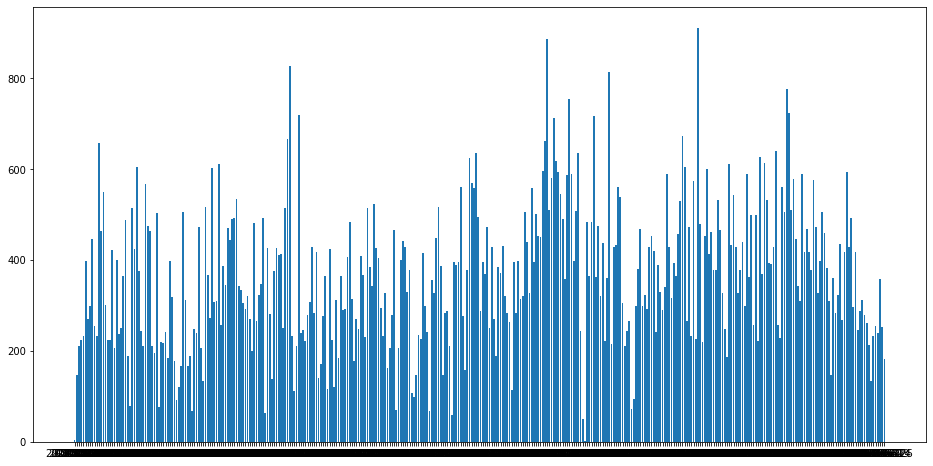

In [64]:
[dates, minPlayed] = np.transpose(np.array(*[res]))
minPlayed = list(map(float, minPlayed))
fig, ax = plt.subplots(figsize=(16, 8))
ax.bar(dates, minPlayed)

This doesn't give us so much information about my listening habits. Except that my record listening time in a day is

In [72]:
date = dates[minPlayed.index(max(minPlayed))]
print(str(max(minPlayed)/60) + " hours on the " + date + "!")

15.2 hours on the 2021-04-02!


Let's look at what happened there!

In [100]:
cmd = """ SELECT 
            endTime,
            msPlayed / 1000
          FROM 
            streaming_history
          WHERE
            date(endTime)='""" + date + "';"

cur = database.execute(cmd)
res = cur.fetchall()

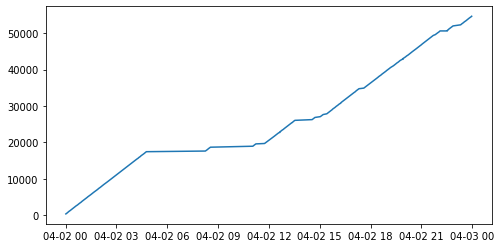

In [112]:
import datetime as dt

[time, secPlayed] = np.transpose(np.array(*[res]))
time = [dt.datetime.strptime(t, "%Y-%m-%d %H:%M") for t in time]
secPlayed = np.cumsum([int(sec) for sec in secPlayed])

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(time, secPlayed)

So the diagonals show when I listened to music, and the horizontals when I didn't.

Interesting would be to see how many hours of music I listen to on the different weekdays. The problem with sqlite is that we can't directly group by weekdays, so we have to find a workaround. We can format the date such that it gives us the last weekday, if it equals the date then it means we have the corresponding weekday.

In [68]:
weekDays = []
for i in range(7):
    cmd = """ SELECT 
                AVG(msPlayed) / 3600000
              FROM (
                SELECT 
                  date, 
                  SUM(msPlayed) AS msPlayed
                FROM (
                  SELECT 
                    date(endTime) AS date, 
                    msPlayed
                  FROM 
                    streaming_history
                  WHERE 
                    date=date(endTime, 'weekday """ + str(i) + """')
                  )
                GROUP BY date
              );       
          """

    cur = database.execute(cmd)
    res = cur.fetchall()
    weekDays.append(res[0][0])

<BarContainer object of 7 artists>

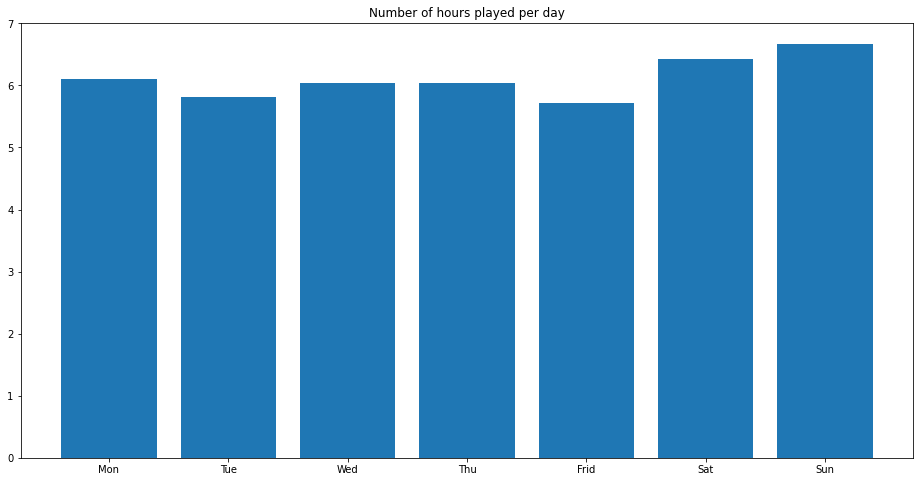

In [113]:
x = ["Mon", "Tue", "Wed", "Thu", "Frid", "Sat", "Sun"]
fig, ax = plt.subplots(figsize=(16, 8))
ax.title.set_text("Number of hours played per day")
ax.bar(x, weekDays)

Around 6 hours on average per day is quite a lot. Friday is the day I listen to least music and Sunday unsurprisingly the most. 

Another interesting statistics could be how much music I listen to at different hours of the day. Here we can use the strftime function which directly gives us the hour, so we can easly group and sum up the time.

In [70]:
cmd = """ 
        SELECT 
          strftime('%H', endTime),
          SUM(msPlayed) / 60000
        FROM
          streaming_history
        GROUP BY
          strftime('%H', endTime);
      """

cur = database.execute(cmd)
res = cur.fetchall()

<BarContainer object of 24 artists>

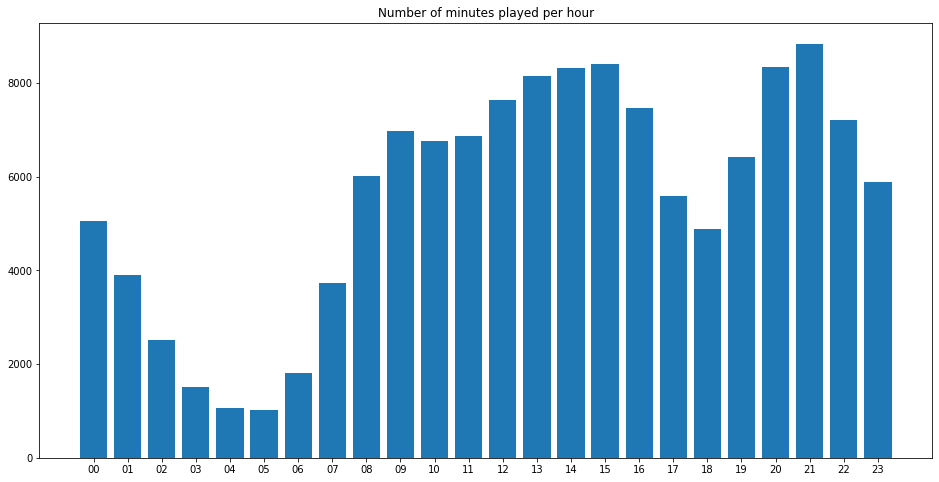

In [71]:
[hours, minutes] = np.array(*[res]).transpose()
fig, ax = plt.subplots(figsize=(16, 8))
ax.title.set_text("Number of minutes played per hour")
ax.bar(hours, list(map(float, minutes)))

Pretty predictable results, at 5 in the morning is when I listen to the least music and at 9 in the evening the most.

Unfortunatly, Spotify doesn't provide the genre of each song, but it provides the genre for each artist. 

In [ ]:
cmd = """SELECT DISTINCT artistName FROM streaming_history;"""
cur = database.execute(cmd)
artist_list = cur.fetchall()

print("We have " + str(len(artist_list)) + " different artists")

We have 3627 different artists


The [Spotipy](https://spotipy.readthedocs.io/en/2.18.0/) library allows us to access all the music data provided by Spotify. The code to install the library:

In [ ]:
pip install spotipy --upgrade

We'll use the client credential flow, which has the advantage that we don't need the user authentification token. [The documentation](https://developer.spotify.com/documentation/general/guides/authorization-guide/#client-credentials-flow) about how you get the credentials needed. 

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

id = '627414d9842a40a9941c69152d1ef5d4'
secret = '9b1249549b214a9e9bd26f45cda8f44a'

auth_manager = SpotifyClientCredentials(client_id=id, client_secret=secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

Because Spotify doesn't provide the genre for each 

In [ ]:
values = []

for item in artist_list:
  artistName = item[0]
  results = sp.search(q=artistName, type='artist')
  
  try:
    results = results["artists"]["items"][0]
    genres = results["genres"]

    for genre in genres:
      value = (artistName, genre)
      values.append(value)
    
  except:
    print("not found: " + artistName)

not found: Asaf Avidan & the Mojos
not found: Benny Benassi presents The Biz
not found: The Explicits
not found: Science Weekly
not found: The Yes Theory Podcast
not found: Radio Headspace
not found: rSlash


In [ ]:
#create
database.execute("""CREATE TABLE IF NOT EXISTS artist_genres(
                    artistName varchar(40),
                    genreName varchar(40),
                    id INTEGER PRIMARY KEY AUTOINCREMENT);""")
database.commit()

In [ ]:
for value in values:
    cmd = """INSERT INTO artist_genres VALUES(?, ?, null);"""
    database.execute(cmd, value)

database.commit()

In [ ]:
cmd = """SELECT * FROM artist_genres LIMIT 5;"""
cur = database.execute(cmd)
res = cur.fetchall()
for r in res:
  print(r)

('Foo Fighters', 'alternative metal', 1)
('Foo Fighters', 'alternative rock', 2)
('Foo Fighters', 'modern rock', 3)
('Foo Fighters', 'permanent wave', 4)
('Foo Fighters', 'post-grunge', 5)


Let's try to get every modern rock from streaming history

In [ ]:
def getGenreStreamingHistory(genre):
  cmd = """ SELECT streaming_history.endTime, streaming_history.artistName, streaming_history.trackName, artist_genres.genreName, streaming_history.msPlayed
            FROM streaming_history
            INNER JOIN artist_genres ON streaming_history.artistName=artist_genres.artistName 
            WHERE artist_genres.genreName='""" + genre + "';"
  cur = database.execute(cmd)
  streaming_history = cur.fetchall()
  return streaming_history

modern_rock_streaming_history = getGenreStreamingHistory("modern rock")
print(modern_rock_streaming_history[:3])

[('2020-06-24 07:45', 'Foo Fighters', 'These Days', 'modern rock', 294417), ('2020-06-28 15:20', 'Foo Fighters', 'Concrete and Gold', 'modern rock', 0), ('2020-07-01 13:25', 'Foo Fighters', 'These Days', 'modern rock', 298266)]


Now let's look at the streaming time.

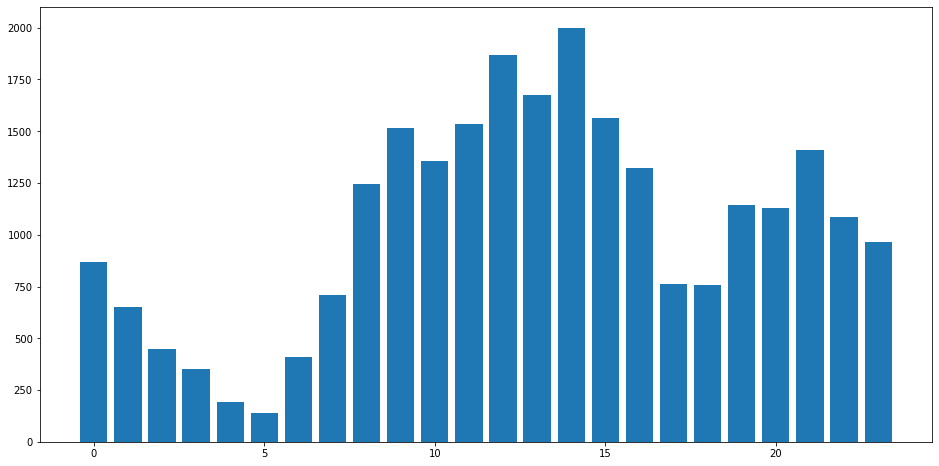

In [ ]:
from datetime import datetime
          
def getHourlyStreamingHistoryCount(time):
  hours = [0 for y in range(24)]
  
  for t in time:
    date = datetime.strptime(t[0], '%Y-%m-%d %H:%M')
    hours[date.hour] += 1
  
  return hours

def getHourlyStreamingHistoryTime(time):
  hours = [0 for y in range(24)]
  
  for t in time:
    date = datetime.strptime(t[0], '%Y-%m-%d %H:%M')
    sec = t[4] / 1000 #seconds played
    min = sec / 60 #minute played
    hours[date.hour] += min
  
  return hours

def plotHourlyStreamingHistory(hours):
  y = [y for y in range(24)]
  fig, ax = plt.subplots(figsize=(16, 8))
  ax.bar(y, hours)
  plt.show()

modern_rock_hourly_history = getHourlyStreamingHistoryTime(modern_rock_streaming_history)
plotHourlyStreamingHistory(modern_rock_hourly_history)

Let's compare that to metal

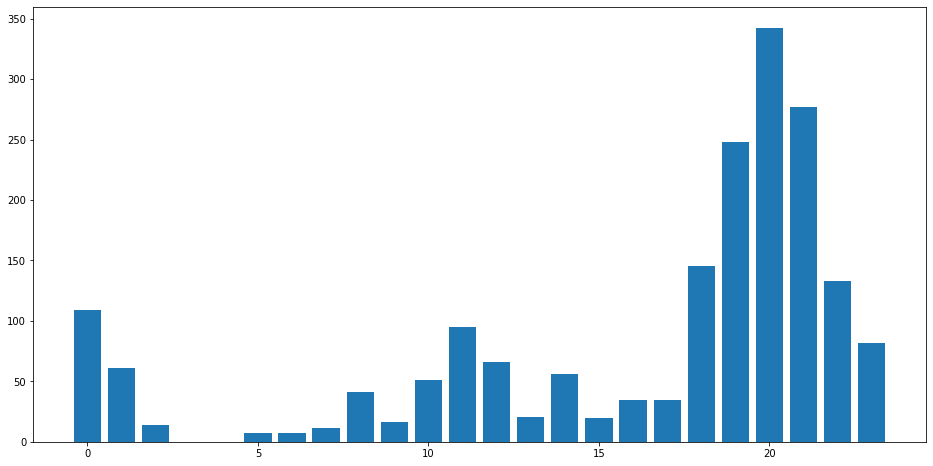

In [ ]:
heavy_metal_streaming_history = getGenreStreamingHistory("metal")
heavy_metal_hourly_history = getHourlyStreamingHistoryTime(heavy_metal_streaming_history)
plotHourlyStreamingHistory(heavy_metal_hourly_history)

To be able to better compare what's going on, let's look at which are the most popular genres and then plot them against each other.

In [ ]:
cmd = """ SELECT genreName, SUM(msPlayed)/(60*1000) FROM
          (
          SELECT artist_genres.genreName, streaming_history.trackName, streaming_history.msPlayed
          FROM streaming_history
          INNER JOIN artist_genres ON streaming_history.artistName=artist_genres.artistName
          )
          GROUP BY genreName
          ORDER BY SUM(msPlayed) DESC;
          """


cur = database.execute(cmd)
res = cur.fetchall()
print("So my most popular streamed genres:")
for i in range(50):
  print(res[i][0] + " : " + str(res[i][1]) + " min")

So my most popular streamed genres:
rock : 31752 min
modern rock : 25099 min
pop : 24104 min
electropop : 13362 min
classic rock : 12931 min
indie poptimism : 10804 min
tropical house : 10609 min
album rock : 10140 min
french indie pop : 9266 min
dance pop : 9179 min
pop rock : 8915 min
edm : 8468 min
permanent wave : 8173 min
art rock : 8152 min
modern alternative rock : 7864 min
pop dance : 7558 min
alternative rock : 7541 min
mellow gold : 7196 min
new french touch : 7067 min
french indietronica : 6888 min
pop rap : 6681 min
soft rock : 6622 min
indie pop : 6491 min
lancaster pa indie : 5780 min
progressive rock : 5693 min
electro house : 5072 min
hard rock : 4749 min
post-teen pop : 4407 min
alternative metal : 4396 min
piano rock : 4379 min
glam rock : 4246 min
electronica : 3928 min
stomp and holler : 3889 min
indie rock : 3821 min
progressive house : 3519 min
ohio hip hop : 3285 min
indietronica : 3195 min
psychedelic rock : 3130 min
rap : 3077 min
nu metal : 2758 min
hip hop : 

Let's look at that on a pie plot.

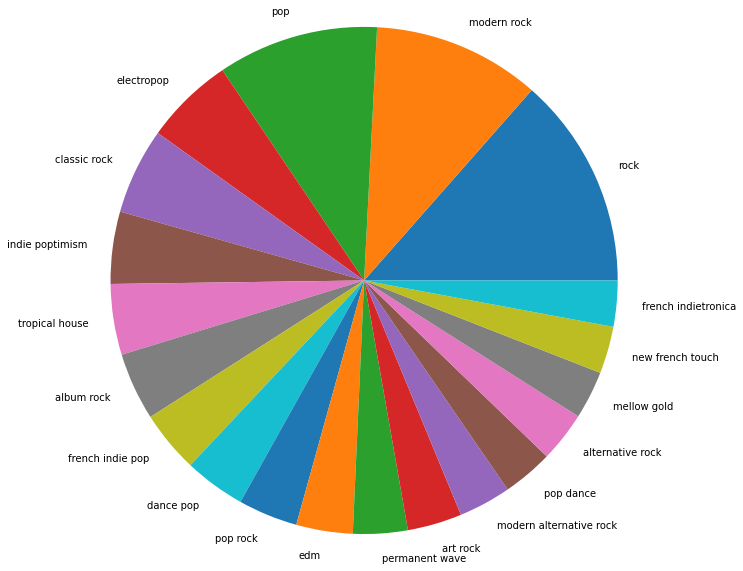

In [ ]:
labels = []
sizes = []

for i in range(20):
  labels.append(res[i][0])
  sizes.append(res[i][1])

fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(sizes, labels=labels)
ax.axis('equal')

plt.show()

Let's take some different genres.

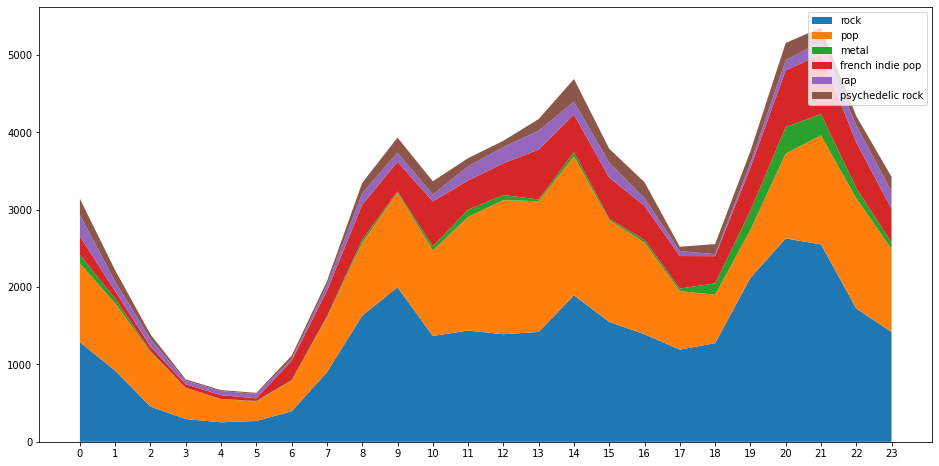

In [ ]:
labels = [str(y) for y in range(24)]
genres = ["rock", "pop", "metal", "french indie pop", "rap", "psychedelic rock"]
fig, ax = plt.subplots(figsize=(16, 8))

hours = {}

for genre in genres:
  hourly = getHourlyStreamingHistoryTime(getGenreStreamingHistory(genre))
  hours[genre] = hourly

ax.stackplot(labels, hours.values(),
             labels=hours.keys())

ax.legend()
plt.show()

In [ ]:
#close
database.close()

# Playlist analysis

In [ ]:
def get_playlist_tracks(username, playlist_id):
  results = sp.user_playlist_tracks(username, playlist_id)
  tracks = results['items']
  while results['next']:
    results = sp.next(results)
    tracks.extend(results['items'])
  return tracks

tracks = get_playlist_tracks("timo1701", "09PpyE5sNUzEduVcpFyjwH")

In [ ]:
print(tracks[21]["track"])

{'album': {'album_type': 'single', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/0r0KdmVS1Er3kaFnl1KPog'}, 'href': 'https://api.spotify.com/v1/artists/0r0KdmVS1Er3kaFnl1KPog', 'id': '0r0KdmVS1Er3kaFnl1KPog', 'name': 'Kwabs', 'type': 'artist', 'uri': 'spotify:artist:0r0KdmVS1Er3kaFnl1KPog'}], 'available_markets': ['AD', 'AE', 'AG', 'AL', 'AM', 'AO', 'AR', 'AT', 'AU', 'AZ', 'BA', 'BB', 'BD', 'BE', 'BF', 'BG', 'BH', 'BI', 'BJ', 'BN', 'BO', 'BR', 'BS', 'BW', 'BY', 'BZ', 'CH', 'CI', 'CL', 'CM', 'CO', 'CR', 'CV', 'CW', 'CY', 'CZ', 'DE', 'DJ', 'DK', 'DM', 'DO', 'DZ', 'EC', 'EE', 'EG', 'ES', 'FI', 'FJ', 'FM', 'FR', 'GA', 'GD', 'GH', 'GM', 'GN', 'GQ', 'GR', 'GT', 'GW', 'HK', 'HN', 'HR', 'HT', 'HU', 'ID', 'IE', 'IL', 'IN', 'IS', 'IT', 'JM', 'JO', 'JP', 'KE', 'KG', 'KH', 'KM', 'KN', 'KR', 'KW', 'KZ', 'LA', 'LB', 'LC', 'LK', 'LR', 'LS', 'LT', 'LU', 'LV', 'MA', 'MC', 'MD', 'ME', 'MG', 'MK', 'ML', 'MN', 'MO', 'MR', 'MT', 'MU', 'MW', 'MY', 'MZ', 'NA', 'NE', 'NG', 'NI', 'N

Let's make a database with the tracks on my playlist. (id, name)

In [ ]:
#create
database.execute("""CREATE TABLE IF NOT EXISTS shazam_tracks(
                    trackId varchar(40),
                    trackName varchar(40),
                    artistName varchar(40),
                    id INTEGER PRIMARY KEY AUTOINCREMENT);""")
database.commit()

In [ ]:
for track in tracks:
    id = track["track"]["id"]
    name = track["track"]["name"]
    artistName = track["track"]["artists"][0]["name"]
    values = [id, name, artistName]

    cmd = """INSERT INTO shazam_tracks VALUES(?, ?, ?, null);"""
    
    database.execute(cmd, values)

database.commit()

In [ ]:
cmd = """SELECT * FROM shazam_tracks LIMIT 5;"""
cur = database.execute(cmd)
res = cur.fetchall()
for r in res:
  print(r)

('5VQU5JJ857w83VUceyt6b9', 'Make Me Fade - Audiotree Live Version', 'K.Flay', 1)
('5KcYtdjhsQrNNMjJOSAUEz', 'Team', 'Lorde', 2)
('4GylZDT7adqIfVoPHyFb5X', 'Speeding Cars', 'Walking On Cars', 3)
('4b30rxe4kxjNl8YpE17Sew', 'Man on a Wire', 'The Script', 4)
('37sINbJZcFdHFAsVNsPq1i', 'Superheroes', 'The Script', 5)


Now let's get the features of the tracks.

In [ ]:
def get_tracks_features(tracks):
  features = []

  for i, t in enumerate(tracks):
    id = t["track"]["id"]
    feature = sp.audio_features(id)
    features.extend(feature)

    if i%100  == 0:
      print(i)

  return features

track_features = get_tracks_features(tracks)

Now let's add the features to a new table

In [ ]:
#create
database.execute("""CREATE TABLE IF NOT EXISTS track_features(
                    danceability FLOAT(4),
                    energy FLOAT(4),
                    key INTEGER,
                    loudness DECIMAL(4, 4),
                    speechiness FLOAT(4),
                    acousticness FLOAT(4),
                    instrumentalness FLOAT(4),
                    liveness FLOAT(4),
                    valence FLOAT(4),
                    tempo DECIMAL(4, 4),
                    trackId varchar(40),
                    duration_ms BIGINT,
                    time_signature INTEGER,
                    id INTEGER PRIMARY KEY AUTOINCREMENT);""")

database.commit()

In [ ]:
keys = ["danceability", "energy", "key", "loudness", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "id", "duration_ms", "time_signature"]

for item in track_features:
    values = [item.get(key, None) for key in keys]
    cmd = """INSERT INTO track_features VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, null);"""
    database.execute(cmd, values)

database.commit()

[Text(0, 0, 'danceability'),
 Text(0, 0, 'energy'),
 Text(0, 0, 'speechiness'),
 Text(0, 0, 'acousticness'),
 Text(0, 0, 'instrumentalness'),
 Text(0, 0, 'liveness'),
 Text(0, 0, 'valence')]

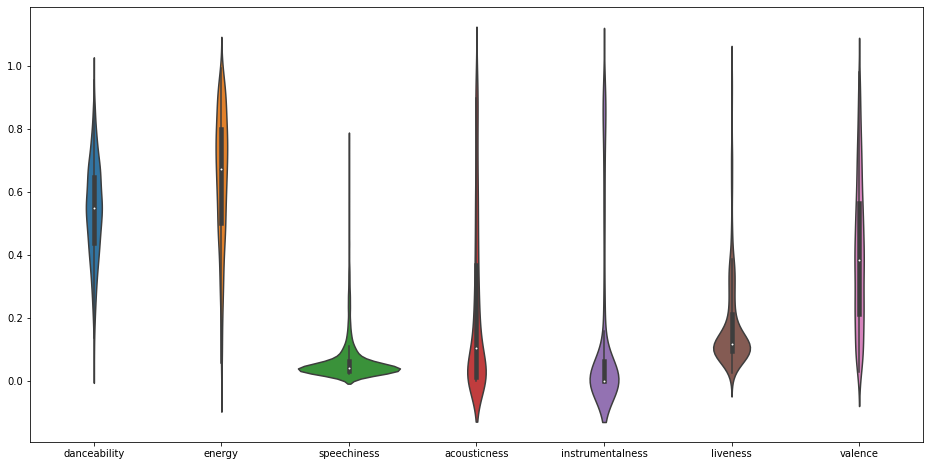

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

keys = ["danceability", "energy", "speechiness", "acousticness", "instrumentalness", "liveness", "valence"]
cmd = "SELECT " + ", ".join(keys) + " FROM track_features;"
cur = database.execute(cmd)
res = cur.fetchall()

features = []
for i in range(7):
  feature = [x[i] for x in res]
  features.append(feature)

fig, ax = plt.subplots(figsize=(16, 8))
s = sns.violinplot(data=features, ax=ax)
s.set_xticklabels(keys)

Let's try to cluster the songs.

In [ ]:
import numpy as np
from sklearn.cluster import KMeans

X = res
n = 10

kmeans = KMeans(n_clusters=n, random_state=0).fit(X)

In [ ]:
cmd = """SELECT * FROM shazam_tracks;"""
cur = database.execute(cmd)
res = cur.fetchall()

labels = kmeans.predict(X)

In [ ]:
playlists = [[] for i in range(n)]

for i in range(len(labels)):
  label = int(labels[i])
  name = res[i][1]
  playlists[label].append(name)

In [ ]:
playlist = playlists[3]
for p in playlist:
  print(p)

Intro
Time
Stay High - Habits Remix
Concrete and Gold
Contact
Strobe - Radio Edit
Where the Boats Go
This Bright Flash
Year One, One Ufo
Echoes of Mine
Heroin
Breathe Me
Lucky
Follow Me - Remastered
Veridis Quo
Soothsayer (Dedicated to Aunt Suzie)
Better
Cut to Black - Instrumental
Orion
Alpha
Nucleogenesis, Pt. 1
Cymatics
Automatica
Terminal Frost - 2011 Remastered Version
Roadgame
21st Century Schizoid Man
Galapogos - Remastered 2012
A Moment Apart
Some Misunderstanding
Strobe
Myrkur
Polaris
The Silence
What Do You Need?
Radioaktivität - 2009 Remaster
Autobahn - 2009 Remaster
Fake Empire
Apocalypse
Sweet Dreams (Are Made Of This)
44 Lies
Apocalypse
Apocalypse
Younger - Boeoes Kaelstigen Remix
Loyal
Territory
Don't Stay Here
Fractures
Tired Of Being Alive
Bridge to Cross
Dime Store Rock
Waste Tomorrow
Luz
Changes
Feeling Magnetic
Annecy
Just Kiss Her
Blood and Rockets - Movement I, Saga of Jack Parsons - Movement II, Too The Moon
Amethyst Realm
Like Fleas
I'm That Guy
La clé des champ

It's pretty clear that they don't really share a common type. We can't really cluster music just because of the similarity in certain metrics.

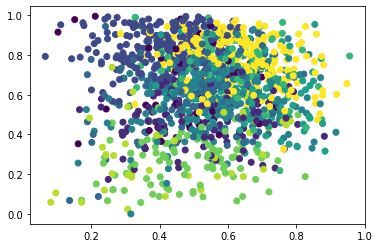

In [ ]:
plt.scatter(features[0], features[1], c=labels, cmap='viridis')

We see that the clustering seems to work on metrics, but doesn't really reflect a genre or common characteristics. 